In [ ]:
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
import os
import pandas as pd
from glob import glob
from tqdm import tqdm
import cv2
import tensorflow as tf

from tensorflow import keras
from tensorflow.keras.preprocessing.image import load_img
from tensorflow.keras.applications.xception import Xception
from tensorflow.keras.applications.xception import preprocess_input
from tensorflow.keras.applications.xception import decode_predictions
from tensorflow.keras.preprocessing.image import ImageDataGenerator

from keras.models import Sequential,Model
from keras.layers import MaxPooling2D,Conv2D,Dense,BatchNormalization,Dropout,GlobalAveragePooling2D,Flatten,Input

# EDA

### 1. Identifying Class Imbalance

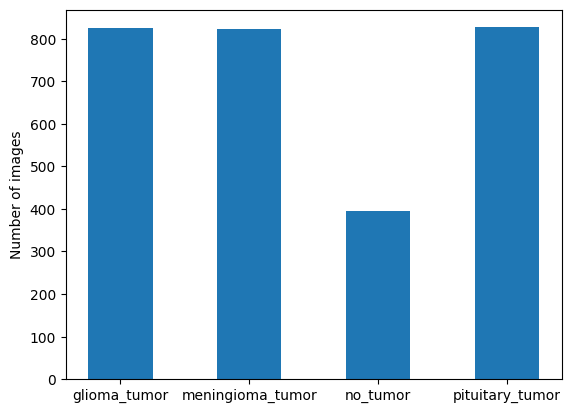

In [1]:
import os
import matplotlib.pyplot as plt
number_classes = {'glioma_tumor': len(os.listdir('./Training/glioma_tumor')),
'meningioma_tumor': len(os.listdir('./Training/meningioma_tumor')),
'no_tumor': len(os.listdir('./Training/no_tumor')),
'pituitary_tumor': len(os.listdir('./Training/pituitary_tumor'))}

plt.bar(number_classes.keys(), number_classes.values(), width = .5);
plt.ylabel('Number of images');

As we can see, there is a lack of no_tumor images, but it isn't significant for our dataset size.

### 2. Plotting Image Size

In [ ]:
from PIL import Image
import dask.bag as db
from dask.diagnostics import ProgressBar

In [14]:
directories = {'glioma': './Training/glioma_tumor/',
'meningioma': './Training/meningioma_tumor/',
'no': './Training/no_tumor/',
'pituitary': './Training/pituitary_tumor/'}

def get_dims(file):
    im = Image.open(file)
    arr = np.array(im)
    h,w,d = arr.shape
    return h,w

[########################################] | 100% Completed | 2.71 ss
[########################################] | 100% Completed | 2.48 ss
[########################################] | 100% Completed | 1.55 ss
[########################################] | 100% Completed | 2.40 ss


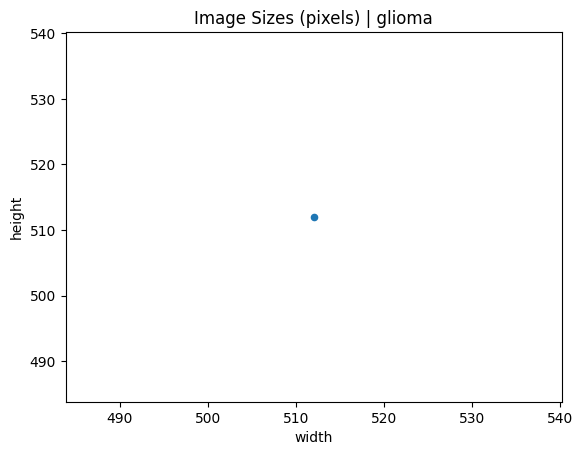

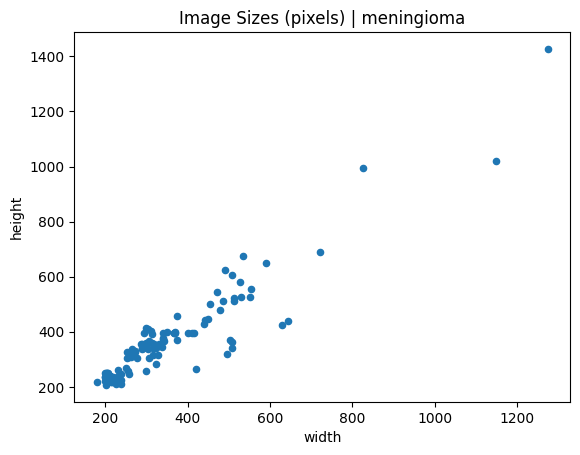

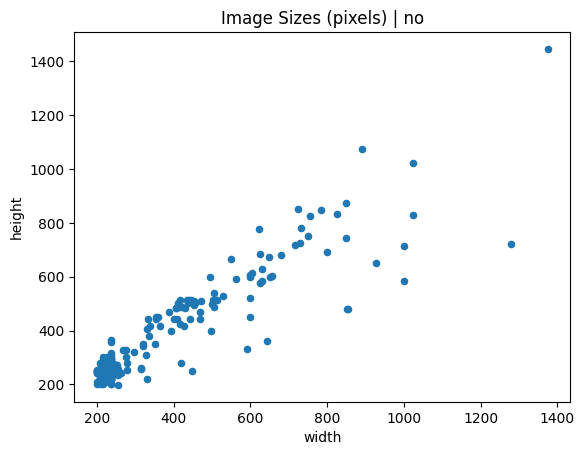

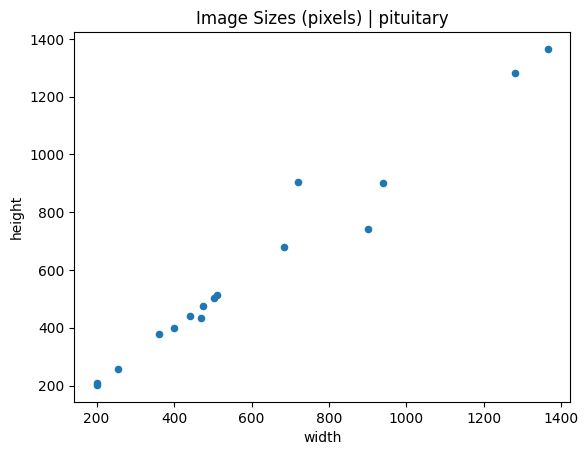

In [15]:
for n,d in directories.items():
    filepath = d
    filelist = [filepath + f for f in os.listdir(filepath)]
    dims = db.from_sequence(filelist).map(get_dims)
    with ProgressBar():
        dims = dims.compute()
        dim_df = pd.DataFrame(dims, columns=['height', 'width'])
        sizes = dim_df.groupby(['height', 'width']).size().reset_index().rename(columns={0:'count'})
        sizes.plot.scatter(x='width', y='height');
        plt.title('Image Sizes (pixels) | {}'.format(n))

# 1st model

In [ ]:
model = Xception(weights='imagenet', input_shape=(299, 299, 3))

In [ ]:
train_gen = ImageDataGenerator(preprocessing_function=preprocess_input)

train_ds = train_gen.flow_from_directory(
    './Training/',
    target_size=(150, 150),
    batch_size=32
)

In [ ]:
val_gen = ImageDataGenerator(preprocessing_function=preprocess_input)

val_ds = val_gen.flow_from_directory(
    './Testing/',
    target_size=(150, 150),
    batch_size=32,
    shuffle=False
)

In [ ]:
train_ds.class_indices

In [ ]:
base_model = Xception(
    weights='imagenet',
    include_top=False,
    input_shape=(150, 150, 3)
)
base_model.trainable = False

inputs = keras.Input(shape=(150, 150, 3))
base = base_model(inputs, training=False)
vectors = keras.layers.GlobalAveragePooling2D()(base)
outputs = keras.layers.Dense(4)(vectors)
model = keras.Model(inputs, outputs)

In [ ]:
def make_model(learning_rate=0.01):
    base_model = Xception(
        weights='imagenet',
        include_top=False,
        input_shape=(150, 150, 3)
    )

    base_model.trainable = False

    inputs = keras.Input(shape=(150, 150, 3))
    base = base_model(inputs, training=False)
    vectors = keras.layers.GlobalAveragePooling2D()(base)
    outputs = keras.layers.Dense(4)(vectors)
    model = keras.Model(inputs, outputs)
    
    optimizer = keras.optimizers.Adam(learning_rate=learning_rate)
    loss = keras.losses.CategoricalCrossentropy(from_logits=True)

    model.compile(
        optimizer=optimizer,
        loss=loss,
        metrics=['accuracy']
    )
    
    return model

### Let's choose the best learning rate

In [ ]:
scores = {}

for lr in [0.0001, 0.001, 0.01, 0.1]:
    print(lr)

    model = make_model(learning_rate=lr)
    history = model.fit(train_ds, epochs=2, validation_data=val_ds)
    scores[lr] = history.history

    print()
    print()

### Best learning rate is 0.01, now lets train 10 epochs with it.

In [ ]:
learning_rate = 0.01
optimizer = keras.optimizers.Adam(learning_rate=learning_rate)
loss = keras.losses.CategoricalCrossentropy(from_logits=True)
model.compile(optimizer=optimizer, loss=loss, metrics=['accuracy'])
history = model.fit(train_ds, epochs=10, validation_data=val_ds)

In [ ]:
model.save("model1.h5")

# 2nd model

### Lets add more layers.

In [ ]:
labels = ['glioma_tumor','no_tumor','meningioma_tumor','pituitary_tumor']

In [ ]:
def convert_image_to_dataset(file_location):
    label=0
    df=pd.DataFrame()
    for category in glob(file_location+'/*'):
        for file in tqdm(glob(category+'/*')):
            img_array=cv2.imread(file)
            img_array=cv2.resize(img_array,(224, 224))
            data=pd.DataFrame({'image':[img_array],'label':[label]})
            df=df.append(data) ##concat
        label+=1
    return df.sample(frac=1).reset_index(drop=True)

In [ ]:
train_data=convert_image_to_dataset('./Training')
train_x=np.array(train_data.image.to_list())

In [ ]:
model_cnn=Sequential()
model_cnn.add(Input(shape=(224,224,3)))
model_cnn.add(Conv2D(128,(3,3)))
model_cnn.add(MaxPooling2D((2,2)))
model_cnn.add(BatchNormalization())
model_cnn.add(Conv2D(64,(3,3)))
model_cnn.add(MaxPooling2D((2,2)))
model_cnn.add(BatchNormalization())
model_cnn.add(Conv2D(32,(3,3)))
model_cnn.add(MaxPooling2D((2,2)))
model_cnn.add(BatchNormalization())
model_cnn.add(Flatten())
model_cnn.add(Dense(128,activation='relu'))
model_cnn.add(Dropout(0.2))
model_cnn.add(Dense(64,activation='relu'))
model_cnn.add(Dense(4,activation='softmax'))
model_cnn.compile(optimizer='adam',loss='sparse_categorical_crossentropy',metrics=['accuracy'])

In [ ]:
r1=model_cnn.fit(train_x,train_data.label,validation_split=0.1,epochs=5)

In [ ]:
xception_model = Xception(weights='imagenet',include_top=False)
for layers in xception_model.layers:
    layers.trainable=False
x=xception_model.output
x=GlobalAveragePooling2D()(x)
x=Dense(128,activation='relu')(x)
x=Dropout(0.15)(x)
output=Dense(4,activation='softmax')(x)
model2=Model(inputs=xception_model.input,outputs=output)
model2.compile(optimizer='adam',loss='sparse_categorical_crossentropy',metrics=['accuracy'])

In [ ]:
r2=model2.fit(train_x,train_data.label,validation_split=0.1,epochs=2)

In [ ]:
model2.save("model2.h5")

# 3nd model: adding XGBOOST

### Take the layer from previous model and train new xgboost model using that layer's output.

In [ ]:
from xgboost import XGBClassifier
from sklearn.metrics import accuracy_score

In [ ]:
new_model = tf.keras.models.Model(
    model2.input,
    model2.get_layer('global_average_pooling2d').output
)

In [ ]:
X_train_features = new_model.predict(train_x)
X_train_features.shape

In [ ]:
xgb = XGBClassifier(objective='multiclass:softmax', learning_rate = 0.1,
              max_depth = 15, n_estimators = 500)
xgb.fit(X_train_features, train_data.label)

In [ ]:
test_data=convert_image_to_dataset('./Testing')
test_x=np.array(test_data.image.to_list())

In [ ]:
X_test_features = new_model.predict(test_x)
y_pred = xgb.predict(X_test_features)

In [ ]:
accuracy_score(y_pred, test_data.label)

In [ ]:
xgb.save_model("model_xgb.h5")